In [96]:
# Load modules, packages, and functions
%run load_modules.ipynb

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [97]:
# Define the data set
classes = [0,1]          # ['Normal , 'Lung Opacity']  
batch_size       = 64
labels_per_class = 32    # Specify how many labelled examples we want per class
No_samples_train_labelled = labels_per_class*len(classes)
No_samples_train = 64
No_samples_test  = 64
IMG_SIZE         = 32
img_dimension = [IMG_SIZE,IMG_SIZE]

# Write log for every "print_every" iteration
print_every = 10

# Load data
%run load_data.ipynb

Connection to dataset established:
patientId    00436515-870c-4b36-a041-de91049b9ab4
x                                             264
y                                             152
width                                         213
height                                        379
Target                                          1
Name: 4, dtype: object
 
Loading training images: 0 / 64
Data loaded: 10 / 64     Remaining time:  0 : 1
Data loaded: 20 / 64     Remaining time:  0 : 1
Data loaded: 30 / 64     Remaining time:  0 : 0
Data loaded: 40 / 64     Remaining time:  0 : 0
Data loaded: 50 / 64     Remaining time:  0 : 0
Data loaded: 60 / 64     Remaining time:  0 : 0
Train data loaded: 64
 
Data loaded: 10 / 64     Remaining time:  0 : 1
Data loaded: 20 / 64     Remaining time:  0 : 0
Data loaded: 30 / 64     Remaining time:  0 : 0
Data loaded: 40 / 64     Remaining time:  0 : 0
Data loaded: 50 / 64     Remaining time:  0 : 0
Data loaded: 60 / 64     Remaining time:  0 : 0
Test dat

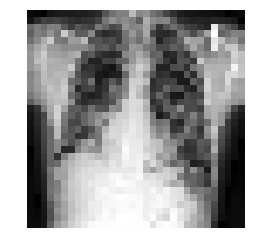

In [98]:
# Show an example image 
im = Image[5]
pylab.imshow(im, cmap=pylab.cm.gist_gray)
pylab.axis('off')

if cuda:
    torch.cuda.max_memory_cached(device=0)
    torch.cuda.memory_allocated(device = 0)

In [99]:
"""
# Construct deep convolutional network as VAE.
# If you want more details run
# print(net)
""" 
%run construct_network.ipynb

# Load loss functions
%run loss_functions.ipynb

# Load functions
# - Balanced accuracy
# - Balanced cross entropy
# - Function to normalize a single image
% run accuracy_functions.ipynb

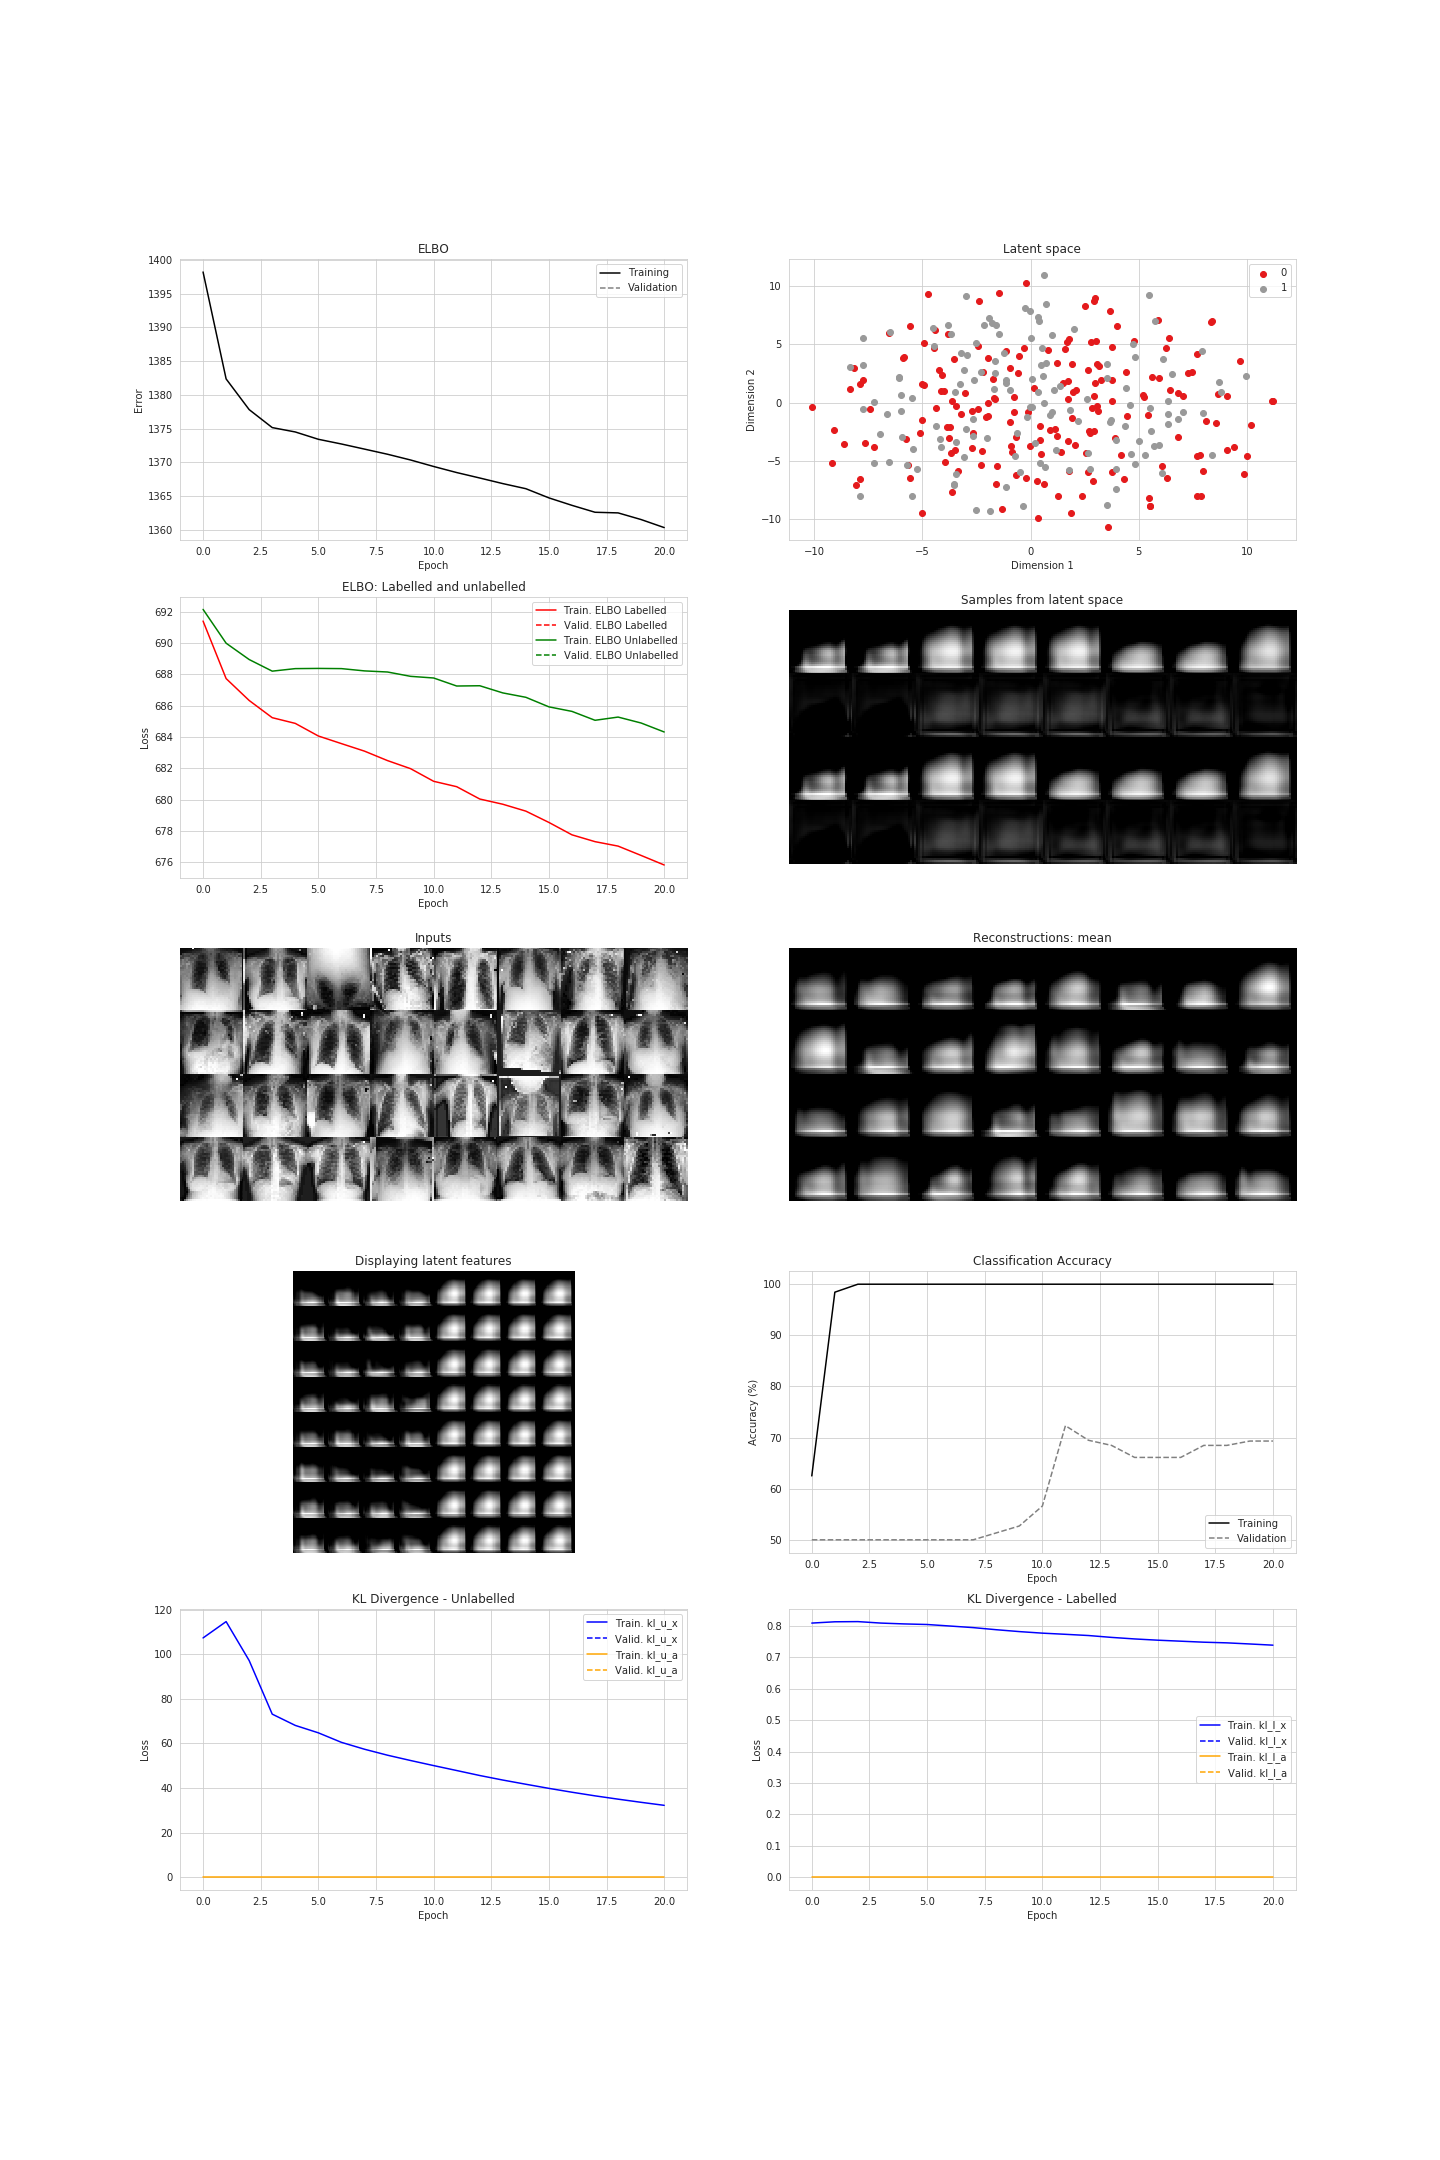

Acc:  tensor(0.6932)
TP:  tensor(140.)
FP:  tensor(50.)
TN:  tensor(85.)
FN:  tensor(45.)
P:  tensor(185.)
N:  tensor(135.)


In [100]:
#### Train network ####
# Number of epochs
num_epochs = 21

# Classification Loss
alpha = 10 * (No_samples_train + No_samples_train_labelled) / No_samples_train_labelled   
print("Weight of classification loss (alpha): ", alpha)

# Latent Loss
beta = 0   

# Deterministic Warm-Up
deterministic_increment = 75  # The increment in the deterministic warmup. n = 10 adds 1/10 to kl_warmup for every epoch.
t_max = 1 # Maximal weight of KL divergence 


print_every = 10       # Display loss functions, latent space, reconstructions, accuracy, ect.
validation_every = 20  # Run model on full test set

# Train network
%run train_network.ipynb

In [101]:
"""
Finally, run trough full test data set to get balanced accuracy
"""

TP, FP, FN, TN, P, N = 0, 0, 0, 0, 0, 0
for (x, y) in test_loader:
    y_hot =  torch.zeros([batch_size,2])
    
    for i in range(len(y)):
        y_hot[i] = torch.tensor([0, 1]) if y[i]==1 else torch.tensor([1, 0])
    x, y, y_hot = Variable(x), Variable(y), Variable(y_hot)
    if cuda:
        # Must be synchronized on the same device
        x, y_hot = x.cuda(device=0), y_hot.cuda(device=0)

    #### Labelled
    outputs = net(x,y_hot)
    logits = outputs["y_hat"]
    y_hot = y_hot.unsqueeze(dim = 1).repeat(1,logits.shape[1],1)
    acc_1, TP_1, FP_1, FN_1, TN_1, P_1, N_1 = balanced_accuracy_test(logits, y_hot)
    TP += TP_1
    FP += FP_1
    FN += FN_1
    TN += TN_1
    P  += P_1
    N  += N_1

acc =  torch.sum(TP/P + TN/N)/2  
print("Acc: ",acc)    
print("TP: ",TP)
print("FP: ",FP)
print("TN: ",TN)
print("FN: ",FN)
print("P: ",P)
print("N: ",N)

Acc:  tensor(0.6932)
TP:  tensor(140.)
FP:  tensor(50.)
TN:  tensor(85.)
FN:  tensor(45.)
P:  tensor(185.)
N:  tensor(135.)
